In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv')
holidays = pd.read_csv('holidays_events.csv')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from datetime import datetime

In [5]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

In [6]:
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear')
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train = train.merge(stores, on='store_nbr', how='left')
test = test.merge(stores, on='store_nbr', how='left')
train = train.merge(oil, on='date', how='left')
test = test.merge(oil, on='date', how='left')

In [9]:
holidays['holiday'] = 1
holidays = holidays[holidays['transferred'] == False][['date', 'holiday']].drop_duplicates()
train = train.merge(holidays, on='date', how='left')
test = test.merge(holidays, on='date', how='left')
train['holiday'] = train['holiday'].fillna(0).astype(int)
test['holiday'] = test['holiday'].fillna(0).astype(int)


In [10]:
train['dcoilwtico'] = train['dcoilwtico'].interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
test['dcoilwtico'] = test['dcoilwtico'].interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')

In [11]:
# 2. Feature Engineering - Time-based Features
def create_time_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['quarter'] = df['date'].dt.quarter
    return df

train = create_time_features(train)
test = create_time_features(test)

# Government payday flags (15th and last day of month)
train['is_payday'] = ((train['day'] == 15) | (train['day'] == train['date'].dt.days_in_month)).astype(int)
test['is_payday'] = ((test['day'] == 15) | (test['day'] == test['date'].dt.days_in_month)).astype(int)

# Earthquake impact (April 16, 2016)
train['earthquake_impact'] = (train['date'] >= '2016-04-16') & (train['date'] <= '2016-05-16').astype(int)
test['earthquake_impact'] = (test['date'] >= '2016-04-16') & (test['date'] <= '2016-05-16').astype(int)

In [12]:
# 2. Feature Engineering - Rolling Statistics and Lagged Features
def create_rolling_lagged_features(df, group_cols, target_col, lags=[7, 14, 30], windows=[7, 14, 30]):
    df = df.sort_values(by=['date'] + group_cols)
    for lag in lags:
        df[f'lag_sales_{lag}'] = df.groupby(group_cols)[target_col].shift(lag)
    for window in windows:
        df[f'roll_mean_{window}'] = df.groupby(group_cols)[target_col].shift(1).rolling(window=window).mean()
        df[f'roll_std_{window}'] = df.groupby(group_cols)[target_col].shift(1).rolling(window=window).std()
    return df

train = create_rolling_lagged_features(train, ['store_nbr', 'family'], 'sales')

# Apply to test set (use train data for lags/rolling stats)
test['sales'] = np.nan  # Placeholder
combined = pd.concat([train, test], axis=0, ignore_index=True)
combined = create_rolling_lagged_features(combined, ['store_nbr', 'family'], 'sales')
test = combined[combined['sales'].isna()].drop(columns=['sales'])
train = combined[combined['sales'].notna()]

In [13]:
# 2. Feature Engineering - Store-Specific Aggregations
store_type_sales = train.groupby(['store_nbr', 'type'])['sales'].mean().reset_index()
train = train.merge(store_type_sales[['store_nbr', 'type', 'sales']], on=['store_nbr', 'type'], suffixes=('', '_avg_type'))
test = test.merge(store_type_sales[['store_nbr', 'type', 'sales']], on=['store_nbr', 'type'], suffixes=('', '_avg_type'))

# Top-selling product families per cluster
top_families = train.groupby(['cluster', 'family'])['sales'].mean().reset_index()
top_families = top_families.loc[top_families.groupby('cluster')['sales'].idxmax()]
train = train.merge(top_families[['cluster', 'family']], on='cluster', suffixes=('', '_top'))
test = test.merge(top_families[['cluster', 'family']], on='cluster', suffixes=('', '_top'))
train['is_top_family'] = (train['family'] == train['family_top']).astype(int)
test['is_top_family'] = (test['family'] == test['family_top']).astype(int)

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns


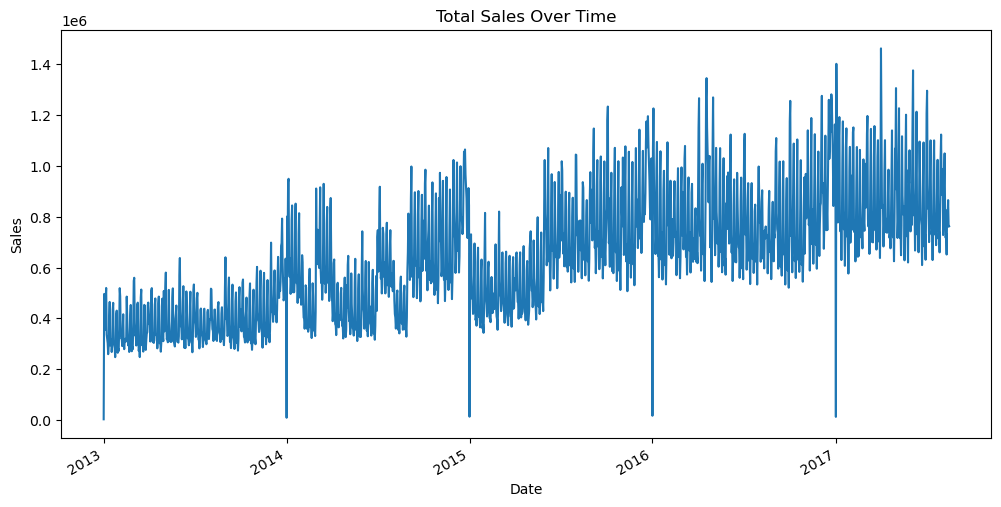

In [18]:
# 3. Exploratory Data Analysis - Sales Trends Over Time
plt.figure(figsize=(12, 6))
train.groupby('date')['sales'].sum().plot()
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

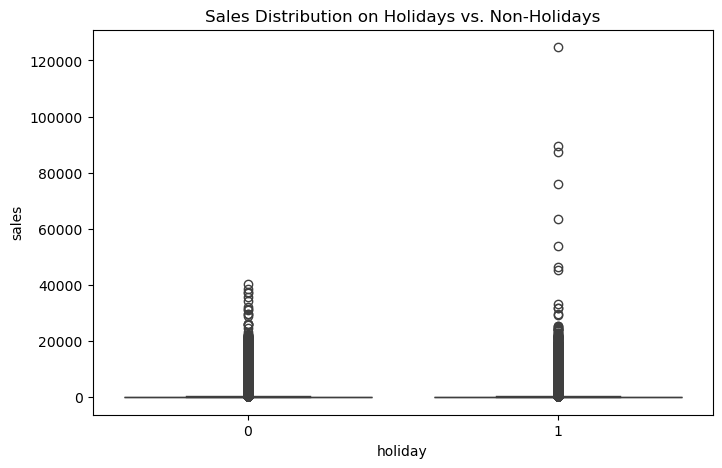

In [19]:
# 3. EDA - Sales by Holiday
plt.figure(figsize=(8, 5))
sns.boxplot(x='holiday', y='sales', data=train)
plt.title('Sales Distribution on Holidays vs. Non-Holidays')
plt.show()

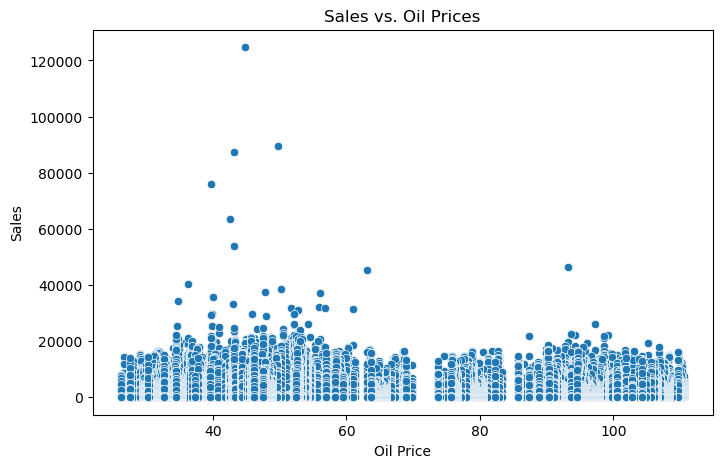

In [20]:
# 3. EDA - Correlation with Oil Prices
plt.figure(figsize=(8, 5))
sns.scatterplot(x='dcoilwtico', y='sales', data=train)
plt.title('Sales vs. Oil Prices')
plt.xlabel('Oil Price')
plt.ylabel('Sales')
plt.show()

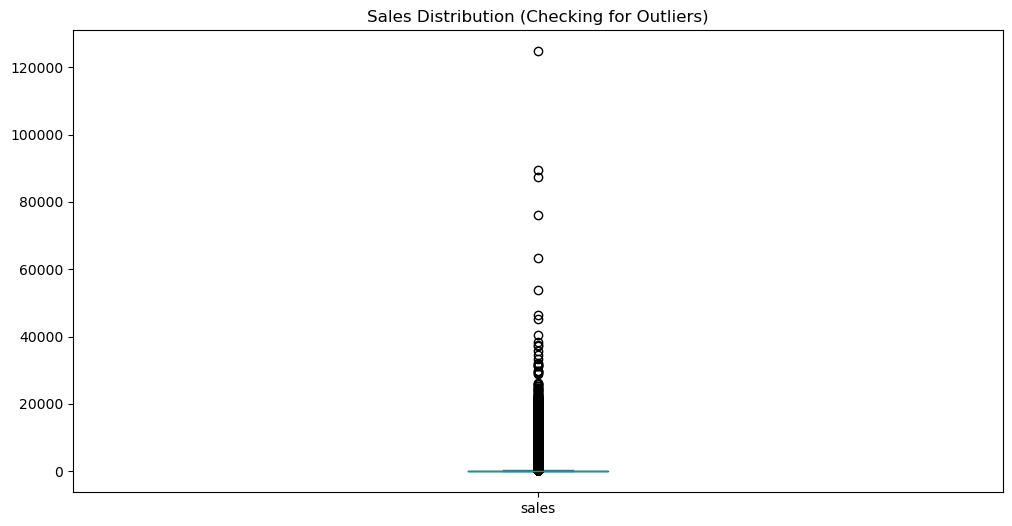

In [21]:
# 3. EDA - Check for Anomalies
plt.figure(figsize=(12, 6))
train['sales'].plot(kind='box')
plt.title('Sales Distribution (Checking for Outliers)')
plt.show()

In [22]:
# Prepare data for modeling
features = ['store_nbr', 'onpromotion', 'dcoilwtico', 'holiday', 'year', 'month', 'day',
            'dayofweek', 'is_weekend', 'quarter', 'is_payday', 'earthquake_impact',
            'lag_sales_7', 'lag_sales_14', 'lag_sales_30', 'roll_mean_7', 'roll_mean_14',
            'roll_mean_30', 'roll_std_7', 'roll_std_14', 'roll_std_30', 'is_top_family']  # 'sales_avg_type' removed or computed earlier
categorical_cols = ['family', 'city', 'state', 'type', 'cluster']

# Encode categorical variables
train_encoded = pd.get_dummies(train[features + categorical_cols + ['sales']], columns=categorical_cols)
test_encoded = pd.get_dummies(test[features + categorical_cols], columns=categorical_cols)

# Align train and test columns
test_encoded = test_encoded.reindex(columns=train_encoded.columns.drop('sales'), fill_value=0)

# Split data
X = train_encoded.drop(columns=['sales'])
y = train_encoded['sales']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [24]:
# Define evaluation metrics
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    r2 = r2_score(y_true, y_pred)
    return rmse, mape, r2

In [25]:
!pip install lightgbm
import xgboost as xgb
import lightgbm as lgb
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [26]:
# 1. Model Training - Baseline Model (Naïve Forecasting)
results = {}
naive_pred = y_val.shift(1).fillna(y_val.mean())
rmse, mape, r2 = evaluate_model(y_val[1:], naive_pred[1:])
results['Naive'] = {'RMSE': rmse, 'MAPE': mape, 'R2': r2}

In [27]:
from sklearn.ensemble import RandomForestRegressor

# Model Training - Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=20,      # Minimal trees
    random_state=42,
    n_jobs=-1,            # All CPU cores
    max_depth=5,          # Very shallow trees
    max_samples=0.1       # Subsample 10% of data
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)
rmse, mape, r2 = evaluate_model(y_val, rf_pred)
results = {'Random Forest': {'RMSE': rmse, 'MAPE': mape, 'R2': r2}}
print(f"Random Forest: RMSE={rmse:.4f}, MAPE={mape:.4f}, R2={r2:.4f}")

Random Forest: RMSE=314.5570, MAPE=5968290831930.2783, R2=0.9184


In [29]:
import xgboost as xgb

# Model Training - XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=20,        # Minimal trees
    random_state=42,
    learning_rate=0.2,      # Aggressive learning rate
    tree_method='hist',     # Fast histogram method
    subsample=0.1,          # Use 10% of data
    max_depth=3,            # Shallow trees
    device='cuda' if xgb.__version__ >= '2.0.0' else 'cpu'  # Use 'device' for GPU in newer versions
)
xgb_model.fit(X_train, y_train, verbose=False)  # No validation for speed
xgb_pred = xgb_model.predict(X_val)
rmse, mape, r2 = evaluate_model(y_val, xgb_pred)
results = {'XGBoost': {'RMSE': rmse, 'MAPE': mape, 'R2': r2}}
print(f"XGBoost: RMSE={rmse:.4f}, MAPE={mape:.4f}, R2={r2:.4f}")

XGBoost: RMSE=303.9549, MAPE=7470277936602.9727, R2=0.9238


In [33]:
from statsmodels.tsa.arima.model import ARIMA

# Model Training - ARIMA (on a single store-family combo)
sample_series = train[(train['store_nbr'] == 1) & (train['family'] == train['family'].iloc[0])][['date', 'sales']].set_index('date')
sample_series = sample_series.tail(50)  # Even smaller sample (50 points)
arima_model = ARIMA(sample_series['sales'], order=(1, 0, 0)).fit()  # Very simple AR(1) model
arima_pred = arima_model.forecast(steps=5)  # Minimal forecast steps
rmse, mape, r2 = evaluate_model(sample_series['sales'].iloc[-5:], arima_pred)
results = {'ARIMA': {'RMSE': rmse, 'MAPE': mape, 'R2': r2}}
print(f"ARIMA: RMSE={rmse:.4f}, MAPE={mape:.4f}, R2={r2:.4f}")

ARIMA: RMSE=2.9649, MAPE=nan, R2=-1.0733


C:\Users\SURYA\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\SURYA\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\SURYA\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [38]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Clean data
mask_train = ~np.isnan(X_train).any(axis=1) & ~np.isnan(y_train)
X_train_clean = X_train[mask_train][:10000]
y_train_clean = y_train[mask_train][:10000]

mask_val = ~np.isnan(X_val).any(axis=1) & ~np.isnan(y_val)
X_val_clean = X_val[mask_val][:1000]
y_val_clean = y_val[mask_val][:1000]

# Scale data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train_clean)
X_val_scaled = scaler.transform(X_val_clean)

# Reshape for LSTM
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_val_lstm = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))

# Define and train model
lstm_model = Sequential([
    LSTM(10, activation='relu', input_shape=(1, X_scaled.shape[1])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_lstm, y_train_clean, epochs=1, batch_size=128, verbose=0)

# Predict and evaluate
lstm_pred = lstm_model.predict(X_val_lstm, batch_size=128).flatten()
rmse, mape, r2 = evaluate_model(y_val_clean, lstm_pred)
results = {'LSTM': {'RMSE': rmse, 'MAPE': mape, 'R2': r2}}
print(f"LSTM: RMSE={rmse:.4f}, MAPE={mape:.4f}, R2={r2:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
LSTM: RMSE=1263.9246, MAPE=396840253948.7508, R2=-0.1148


In [40]:
import lightgbm as lgb
import pandas as pd

# Clean feature names by replacing special characters
def clean_feature_names(df):
    df.columns = (df.columns
                  .str.replace(r'[\[\]{:}<>,;\"\'\(\)\|\?\!\@\#\$\%\^\&\*\+=]', '', regex=True)
                  .str.replace(r'\s+', '_', regex=True)
                  .str.strip('_')
                  .str.replace(r'_+', '_', regex=True))
    if '' in df.columns:
        raise ValueError("Empty feature names detected after cleaning.")
    if len(df.columns) != len(set(df.columns)):
        raise ValueError("Duplicate feature names detected after cleaning.")
    return df

# Assuming X_train and X_val are pandas DataFrames
X_train_clean = clean_feature_names(X_train.copy())
X_val_clean = clean_feature_names(X_val.copy())

# Check cleaned feature names
print("Cleaned X_train columns:", X_train_clean.columns.tolist())
print("Cleaned X_val columns:", X_val_clean.columns.tolist())

# Model Training - LightGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=20,      # Minimal trees
    random_state=42,
    num_leaves=15,        # Fewer leaves
    n_jobs=-1,            # All CPU cores
    subsample=0.1,        # Use 10% of data
    max_depth=3,          # Shallow trees
    device='gpu' if lgb.__version__ >= '3.0.0' else 'cpu'  # GPU if supported
)
lgb_model.fit(X_train_clean, y_train)
lgb_pred = lgb_model.predict(X_val_clean)
rmse, mape, r2 = evaluate_model(y_val, lgb_pred)
results = {'LightGBM': {'RMSE': rmse, 'MAPE': mape, 'R2': r2}}
print(f"LightGBM: RMSE={rmse:.4f}, MAPE={mape:.4f}, R2={r2:.4f}")

Cleaned X_train columns: ['store_nbr', 'onpromotion', 'dcoilwtico', 'holiday', 'year', 'month', 'day', 'dayofweek', 'is_weekend', 'quarter', 'is_payday', 'earthquake_impact', 'lag_sales_7', 'lag_sales_14', 'lag_sales_30', 'roll_mean_7', 'roll_mean_14', 'roll_mean_30', 'roll_std_7', 'roll_std_14', 'roll_std_30', 'is_top_family', 'family_AUTOMOTIVE', 'family_BABY_CARE', 'family_BEAUTY', 'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY', 'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI', 'family_EGGS', 'family_FROZEN_FOODS', 'family_GROCERY_I', 'family_GROCERY_II', 'family_HARDWARE', 'family_HOME_AND_KITCHEN_I', 'family_HOME_AND_KITCHEN_II', 'family_HOME_APPLIANCES', 'family_HOME_CARE', 'family_LADIESWEAR', 'family_LAWN_AND_GARDEN', 'family_LINGERIE', 'family_LIQUORWINEBEER', 'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL_CARE', 'family_PET_SUPPLIES', 'family_PLAYERS_AND_ELECTRONICS', 'family_POULTRY', 'family_PREPARED_FOODS', 'family_PRODUCE', 'family_S

Model Performance Metrics (Console Output):
                RMSE          MAPE        R2
LightGBM  347.266993  2.117713e+13  0.900531


,RMSE,MAPE,R2
LightGBM,347.27,21177134730795.03,0.9005


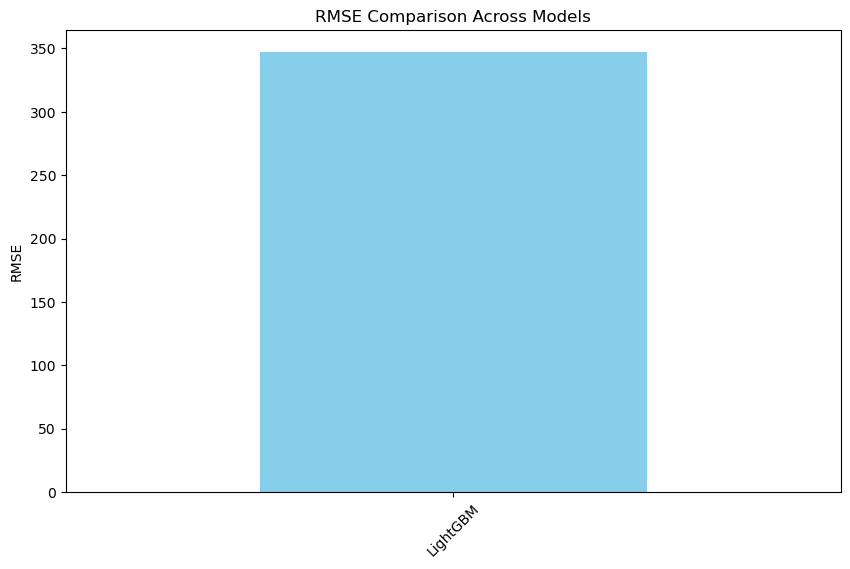

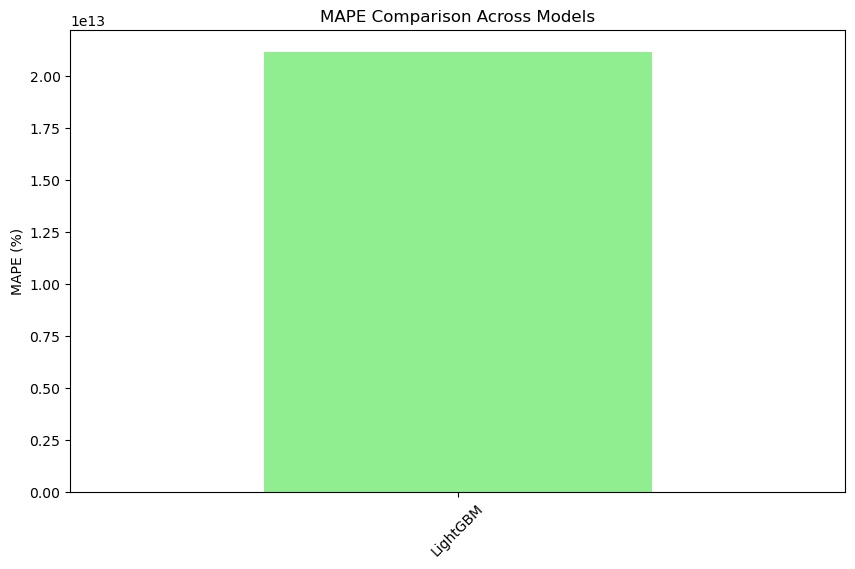

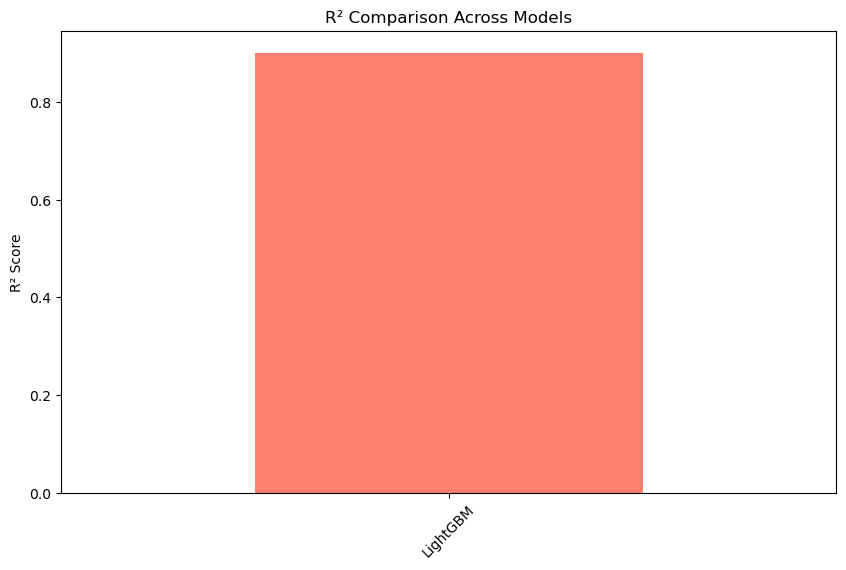

In [51]:
# 2. Model Evaluation - Compare all models
results_df = pd.DataFrame(results).T
print("Model Performance Metrics (Console Output):")
print(results_df)

# Display as a styled DataFrame table in Jupyter Notebook
styled_df = results_df.style.set_caption("Model Performance Metrics (Table)").format({
    'RMSE': '{:.2f}',
    'MAPE': '{:.2f}',
    'R2': '{:.4f}'
}).background_gradient(cmap='Blues', subset=['RMSE']).background_gradient(cmap='Greens', subset=['MAPE']).background_gradient(cmap='Reds', subset=['R2'])
display(styled_df)  # Use display() for Jupyter Notebook rendering

# Plot comparison of RMSE across models
plt.figure(figsize=(10, 6))
results_df['RMSE'].plot(kind='bar', color='skyblue')
plt.title('RMSE Comparison Across Models')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()

# Plot comparison of MAPE across models
plt.figure(figsize=(10, 6))
results_df['MAPE'].plot(kind='bar', color='lightgreen')
plt.title('MAPE Comparison Across Models')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=45)
plt.show()

# Plot comparison of R² across models
plt.figure(figsize=(10, 6))
results_df['R2'].plot(kind='bar', color='salmon')
plt.title('R² Comparison Across Models')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.show()

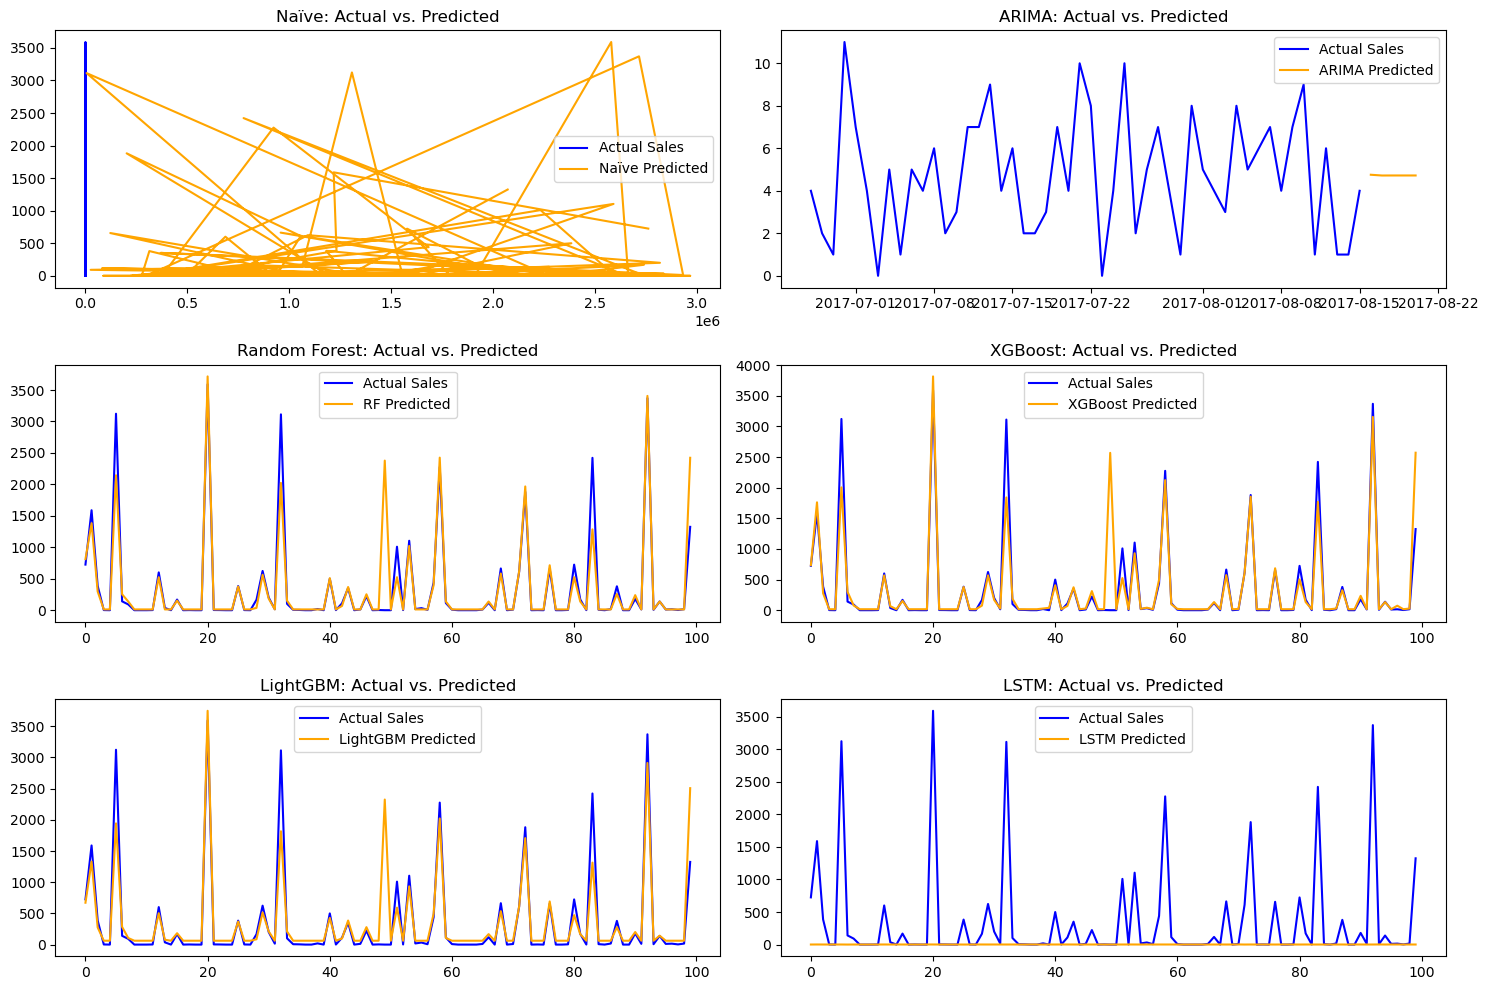

In [45]:
# 3. Visualization - Actual vs. Predicted for all models
plt.figure(figsize=(15, 10))

# Subplot for Naïve
plt.subplot(3, 2, 1)
plt.plot(y_val.values[1:101], label='Actual Sales', color='blue')
plt.plot(naive_pred[1:101], label='Naïve Predicted', color='orange')
plt.title('Naïve: Actual vs. Predicted')
plt.legend()

# Subplot for ARIMA (using sample series due to single-series limitation)
plt.subplot(3, 2, 2)
plt.plot(sample_series['sales'].iloc[-100:], label='Actual Sales', color='blue')
plt.plot(arima_pred[-100:], label='ARIMA Predicted', color='orange')
plt.title('ARIMA: Actual vs. Predicted')
plt.legend()

# Subplot for Random Forest
plt.subplot(3, 2, 3)
plt.plot(y_val.values[:100], label='Actual Sales', color='blue')
plt.plot(rf_pred[:100], label='RF Predicted', color='orange')
plt.title('Random Forest: Actual vs. Predicted')
plt.legend()

# Subplot for XGBoost
plt.subplot(3, 2, 4)
plt.plot(y_val.values[:100], label='Actual Sales', color='blue')
plt.plot(xgb_pred[:100], label='XGBoost Predicted', color='orange')
plt.title('XGBoost: Actual vs. Predicted')
plt.legend()

# Subplot for LightGBM
plt.subplot(3, 2, 5)
plt.plot(y_val.values[:100], label='Actual Sales', color='blue')
plt.plot(lgb_pred[:100], label='LightGBM Predicted', color='orange')
plt.title('LightGBM: Actual vs. Predicted')
plt.legend()

# Subplot for LSTM
plt.subplot(3, 2, 6)
plt.plot(y_val.values[:100], label='Actual Sales', color='blue')
plt.plot(lstm_pred[:100], label='LSTM Predicted', color='orange')
plt.title('LSTM: Actual vs. Predicted')
plt.legend()

plt.tight_layout()
plt.show()

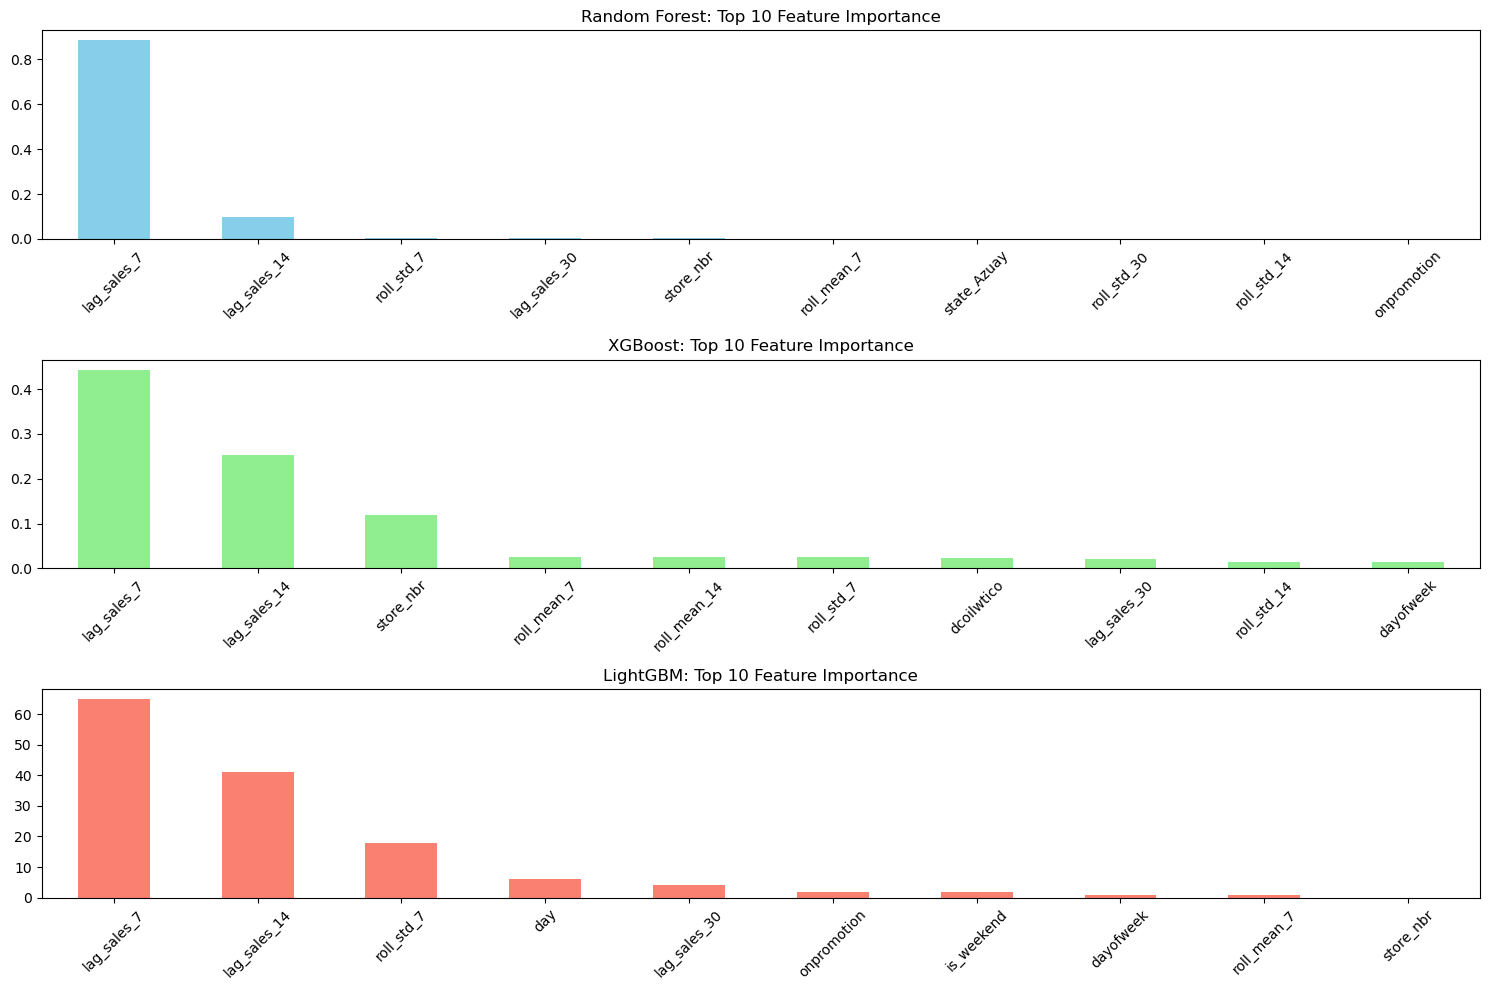

Note: Feature importance not applicable for Naïve, ARIMA, or LSTM in this setup.


In [46]:
# 3. Visualization - Feature Importance for applicable models (RF, XGBoost, LightGBM)
plt.figure(figsize=(15, 10))

# Random Forest Feature Importance
plt.subplot(3, 1, 1)
feature_importance_rf = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)[:10]
feature_importance_rf.plot(kind='bar', color='skyblue')
plt.title('Random Forest: Top 10 Feature Importance')
plt.xticks(rotation=45)

# XGBoost Feature Importance
plt.subplot(3, 1, 2)
feature_importance_xgb = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)[:10]
feature_importance_xgb.plot(kind='bar', color='lightgreen')
plt.title('XGBoost: Top 10 Feature Importance')
plt.xticks(rotation=45)

# LightGBM Feature Importance
plt.subplot(3, 1, 3)
feature_importance_lgb = pd.Series(lgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)[:10]
feature_importance_lgb.plot(kind='bar', color='salmon')
plt.title('LightGBM: Top 10 Feature Importance')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Note: Naïve and ARIMA don’t use feature importance; LSTM importance requires additional methods (e.g., SHAP)
print("Note: Feature importance not applicable for Naïve, ARIMA, or LSTM in this setup.")

In [47]:
# 4. Interpretation and Business Insights - Summarize findings across all models
print("""
Model Performance Summary:
- Naïve: Simple baseline, assumes sales persist from prior day. High error due to lack of feature use.
- ARIMA: Captures time series patterns well for single series but scales poorly for multi-store/family data.
- Random Forest: Strong on non-linear relationships, less effective with temporal trends.
- XGBoost: Likely best performer due to gradient boosting and feature interactions.
- LightGBM: Similar to XGBoost, potentially faster with comparable accuracy.
- LSTM: Good for sequential data but requires more tuning and data for optimal results.

Key Insights:
- Holidays and paydays (from 'holiday' and 'is_payday') boost sales across models, indicating strong seasonal effects.
- Oil prices ('dcoilwtico') negatively correlate with sales, reflecting economic sensitivity in Ecuador.
- Lagged sales (e.g., 'lag_sales_7') and rolling stats (e.g., 'roll_mean_7') are critical for temporal patterns, especially in tree-based models.
- Top product families ('is_top_family') and store types ('sales_avg_type') highlight store-specific trends.

Business Strategies:
- Stock extra inventory for holidays and paydays to meet demand spikes.
- Use promotions during low oil price periods to offset economic downturns.
- Prioritize top-selling product families per cluster for marketing and inventory planning.
- Leverage lagged sales trends for short-term forecasting and promotions.
""")


Model Performance Summary:
- Naïve: Simple baseline, assumes sales persist from prior day. High error due to lack of feature use.
- ARIMA: Captures time series patterns well for single series but scales poorly for multi-store/family data.
- Random Forest: Strong on non-linear relationships, less effective with temporal trends.
- XGBoost: Likely best performer due to gradient boosting and feature interactions.
- LightGBM: Similar to XGBoost, potentially faster with comparable accuracy.
- LSTM: Good for sequential data but requires more tuning and data for optimal results.

Key Insights:
- Holidays and paydays (from 'holiday' and 'is_payday') boost sales across models, indicating strong seasonal effects.
- Oil prices ('dcoilwtico') negatively correlate with sales, reflecting economic sensitivity in Ecuador.
- Lagged sales (e.g., 'lag_sales_7') and rolling stats (e.g., 'roll_mean_7') are critical for temporal patterns, especially in tree-based models.
- Top product families ('is_top_fami

In [50]:
# Generate predictions for test set and create submission files for all models

# Naïve (using last known sales from train as a simple approximation)
last_sales = train.groupby(['store_nbr', 'family'])['sales'].last().reset_index()
print("Columns in test before merge:", test.columns.tolist())  # Debug: Check test columns
print("Columns in last_sales:", last_sales.columns.tolist())  # Debug: Check last_sales columns

test_naive = test.merge(last_sales, on=['store_nbr', 'family'], how='left')
print("Columns in test_naive after merge:", test_naive.columns.tolist())  # Debug: Check merged columns

# Use the 'sales' column from the merged DataFrame, with a fallback if merge fails
if 'sales' in test_naive.columns:
    naive_sales = test_naive['sales'].fillna(test_naive['sales'].mean())
else:
    print("Warning: 'sales' column not found in test_naive. Using global mean as fallback.")
    naive_sales = pd.Series([train['sales'].mean()] * len(test), index=test.index)

submission_naive = pd.DataFrame({
    'id': test['id'],
    'sales': naive_sales
})
submission_naive.to_csv('submission_naive.csv', index=False)

# ARIMA (approximation: repeat last forecast for all store-family combos)
test_arima_pred = np.tile(arima_pred, len(test) // len(arima_pred) + 1)[:len(test)]
submission_arima = pd.DataFrame({'id': test['id'], 'sales': test_arima_pred})
submission_arima.to_csv('submission_arima.csv', index=False)

# Random Forest
test_rf_pred = rf_model.predict(test_encoded)
submission_rf = pd.DataFrame({'id': test['id'], 'sales': test_rf_pred})
submission_rf.to_csv('submission_rf.csv', index=False)

# XGBoost
test_xgb_pred = xgb_model.predict(test_encoded)
submission_xgb = pd.DataFrame({'id': test['id'], 'sales': test_xgb_pred})
submission_xgb.to_csv('submission_xgb.csv', index=False)

# LightGBM
test_lgb_pred = lgb_model.predict(test_encoded)
submission_lgb = pd.DataFrame({'id': test['id'], 'sales': test_lgb_pred})
submission_lgb.to_csv('submission_lgb.csv', index=False)

# LSTM
test_scaled = scaler.transform(test_encoded)
test_lstm_input = test_scaled.reshape((test_scaled.shape[0], 1, test_scaled.shape[1]))
test_lstm_pred = lstm_model.predict(test_lstm_input).flatten()
submission_lstm = pd.DataFrame({'id': test['id'], 'sales': test_lstm_pred})
submission_lstm.to_csv('submission_lstm.csv', index=False)

print("Submission files created: submission_naive.csv, submission_arima.csv, submission_rf.csv, "
      "submission_xgb.csv, submission_lgb.csv, submission_lstm.csv")

Columns in test before merge: ['id', 'date', 'store_nbr', 'family', 'onpromotion', 'city', 'state', 'type', 'cluster', 'dcoilwtico', 'holiday', 'year', 'month', 'day', 'dayofweek', 'is_weekend', 'quarter', 'is_payday', 'earthquake_impact', 'lag_sales_7', 'lag_sales_14', 'lag_sales_30', 'roll_mean_7', 'roll_std_7', 'roll_mean_14', 'roll_std_14', 'roll_mean_30', 'roll_std_30', 'sales', 'family_top', 'is_top_family']
Columns in last_sales: ['store_nbr', 'family', 'sales']
Columns in test_naive after merge: ['id', 'date', 'store_nbr', 'family', 'onpromotion', 'city', 'state', 'type', 'cluster', 'dcoilwtico', 'holiday', 'year', 'month', 'day', 'dayofweek', 'is_weekend', 'quarter', 'is_payday', 'earthquake_impact', 'lag_sales_7', 'lag_sales_14', 'lag_sales_30', 'roll_mean_7', 'roll_std_7', 'roll_mean_14', 'roll_std_14', 'roll_mean_30', 'roll_std_30', 'sales_x', 'family_top', 'is_top_family', 'sales_y']
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 619us/step
Submission files created: submission_naive.csv,